In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import os
from datetime import datetime
import matplotlib.dates as mdates
from scipy.stats import zscore


In [2]:
FS = 4 # E4 sampling rate

DATA_FOLDER_PATH = '/media/bayesian-posterior/sdc/sensecode_data/cwt_data/'
DATA_FOLDER = os.fsencode(DATA_FOLDER_PATH)

# DAYS_ARRAY = np.asarray([0.5, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31])
DAYS_ARRAY = np.asarray([0.5, 1, 7])
FREQ_ARRAY = 1 / (DAYS_ARRAY * 24 * 60 * 60) # for morlet
FREQ_NAMES = ["{:.1f}".format(day)+' Day(s)' for day in DAYS_ARRAY]

PANDAS_RESAMPLE_RATE = "{:.2f}".format(1/4)+'S' # find missing samples (datetime)
PANDAS_RESAMPLE_RATE

'0.25S'

In [3]:
HDRS_17_CUTOFF = 20
HDRS_24_CUTOFF = 10
RCI_HDRS_17 = 6

LABEL_FOLDER_PATH = 'labels/'

In [4]:
def find_sig_HDRS_change(HDRS_array : np.ndarray, 
                         RCI = RCI_HDRS_17, 
                         HDRS_cutoff = HDRS_17_CUTOFF):
    
    # return np.asarray([True if x/HDRS_array[0] <= 0.5 else False for x in HDRS_array])
        
    depressed_week = HDRS_array >= HDRS_cutoff
    # worsened_week = np.asarray([True if x - HDRS_array[0] > RCI_HDRS_17 else False for x in HDRS_array])
    return depressed_week
    # worsened_week =  np.diff(HDRS_array) > RCI_HDRS_17
    # worsened_week = np.insert(worsened_week, 0, False)
    
    # return worsened_week

#     assert len(depressed_week) == len(worsened_week)
    
    # return np.logical_or(depressed_week, worsened_week)

In [5]:
def plot_morlet(df_eda, 
                freq_names, 
                tick_freq, 
                subject,
                HDRS_array,
                sig_change_dates): # dates with significant deterioration
    
    if len(sig_change_dates) > 0:
        resampled_df = df_eda[freq_names].resample(tick_freq).mean()
        cwtm = resampled_df.to_numpy().T # (len(freq_list), len(t))

        tick_freq_dict = {'T':60*24*7, 'H':24*7, 'D':7, 'W':1}
        to_second_dict = {'T':60, 'H':60*60, 'D':24*60*60, 'W':7*24*60*60}
        xtick_freq = tick_freq_dict[tick_freq]

        fig, ax = plt.subplots(figsize=(15, 3)) 
        t = resampled_df.index.to_pydatetime()
        
        min_vec = np.min(cwtm, axis = 1)[:, np.newaxis]
        max_vec = np.max(cwtm, axis = 1)[:, np.newaxis]
        sns.heatmap(cwtm,
                    norm=LogNorm(vmin=cwtm.min(), vmax=cwtm.max()),
                    cmap="Blues",
                    ax=ax)
        
        for idx, date in sig_change_dates.items():
            E4_start_date = t[0].replace(tzinfo=None)
            E4_end_date = t[-1].replace(tzinfo=None)
            
            if date[0].isdigit():
                date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
                if date >= E4_start_date and date <= E4_end_date:
                    position = int((date - E4_start_date).total_seconds()/to_second_dict[tick_freq] + 12*60*60/to_second_dict[tick_freq]) # move the tick to the middle
                    # vline_label = date.strftime("%Y-%m-%d") + ' HDRS: ' + str(HDRS_array[idx])
                    vline_label = str(HDRS_array[idx])
                    
                    if HDRS_array[idx] >= HDRS_17_CUTOFF:
                        ax.axvline(position, color = 'red', alpha = 0.7)
                    else:
                        ax.axvline(position, color = 'green', alpha = 0.7)
                    ax.text(position, 0, vline_label)
        # plt.legend(loc=1)
        

        ax.set_xticks(np.arange(len(t))[::xtick_freq], [xt.strftime('%Y-%m-%d') for xt in t[::xtick_freq]], rotation='vertical')
        ax.set_yticks(np.arange(len(freq_names))+0.5, freq_names, rotation='horizontal')
        ax.set_title(subject, y = 1.1)

/tmp/ipykernel_12042/792977323.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(15, 3))


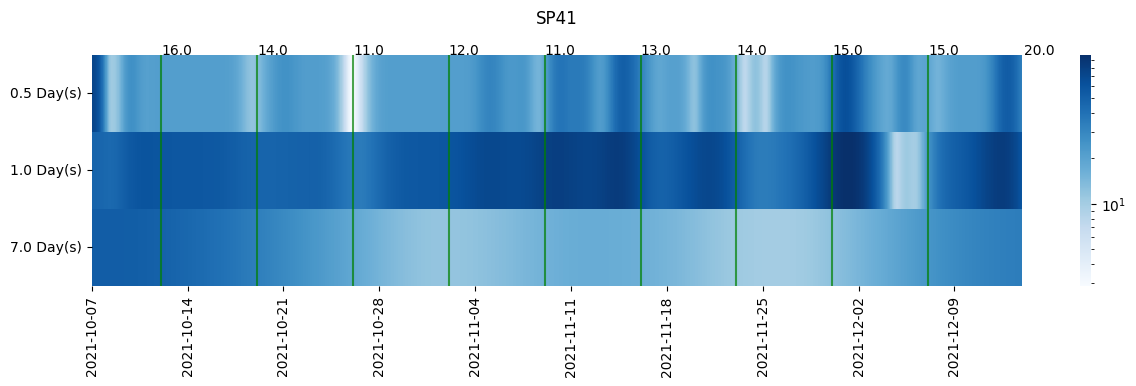

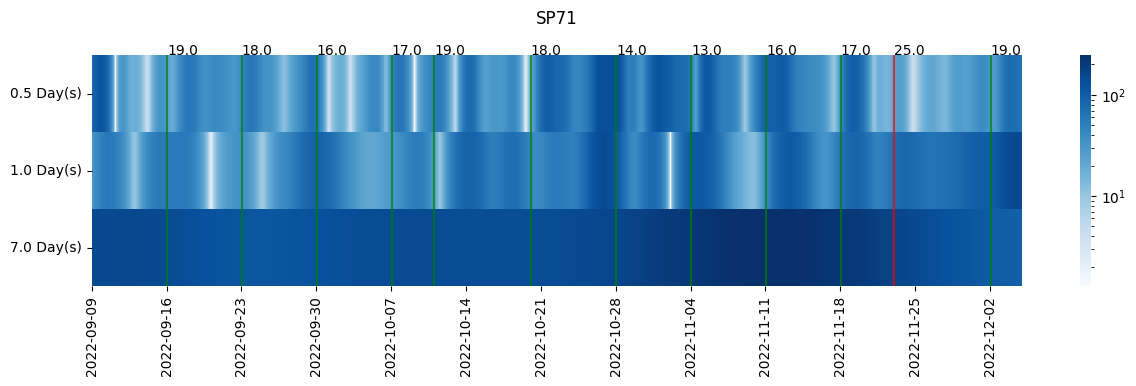

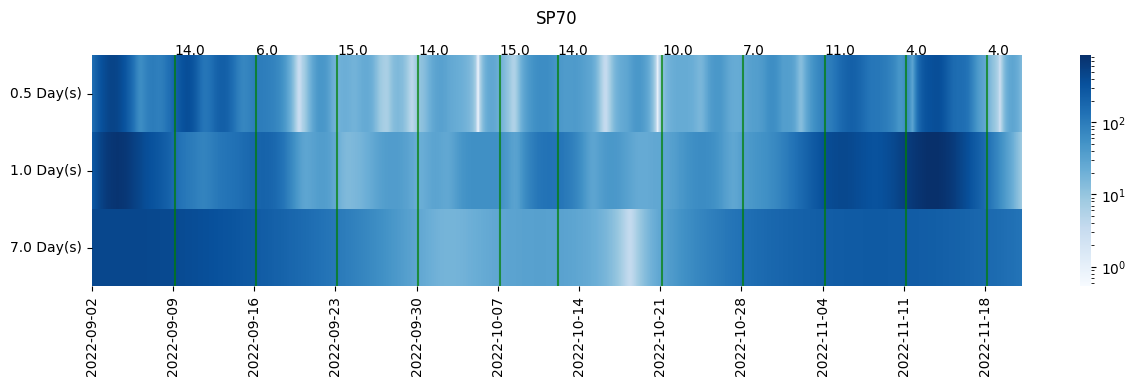

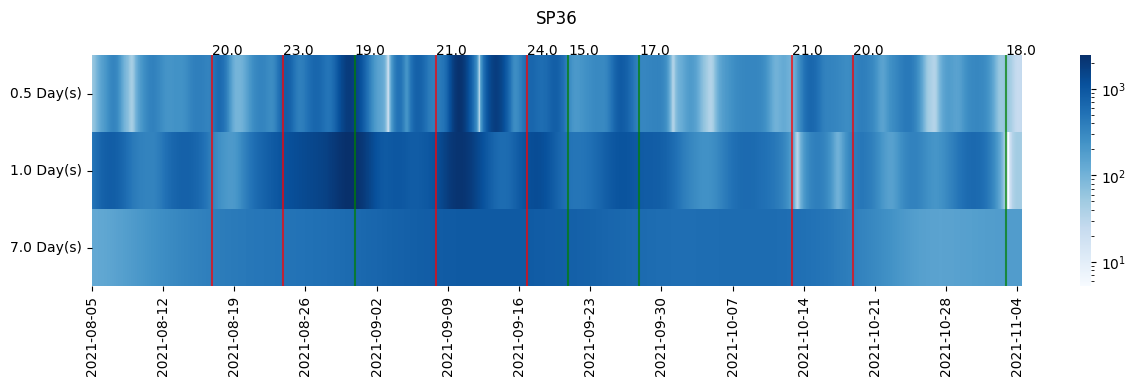

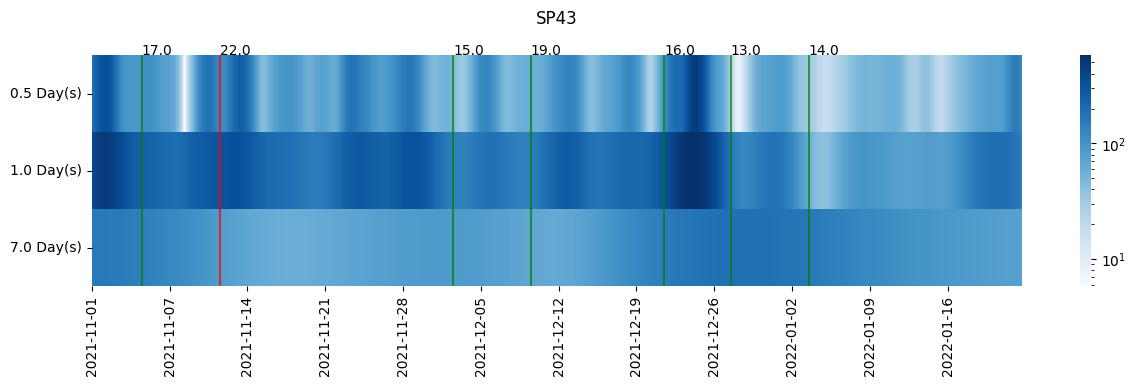

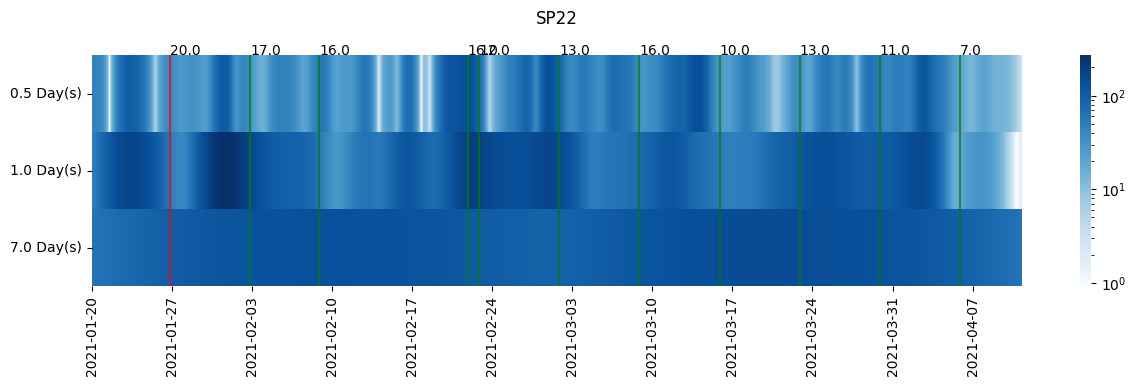

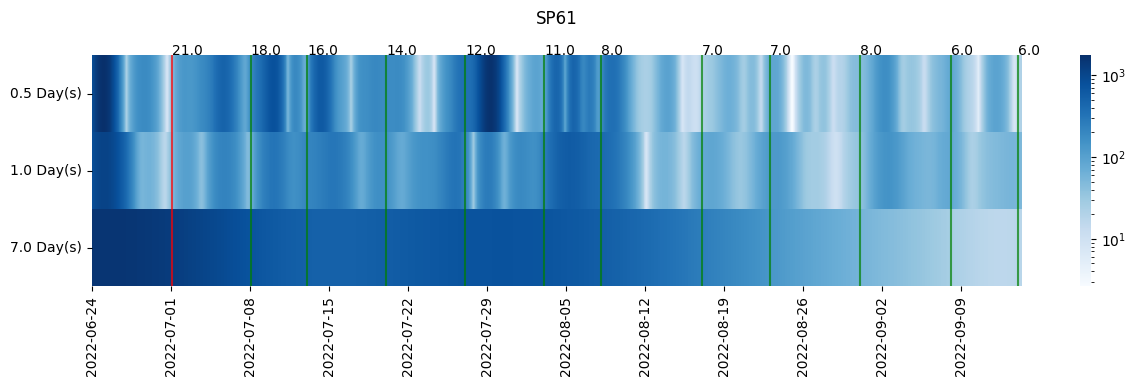

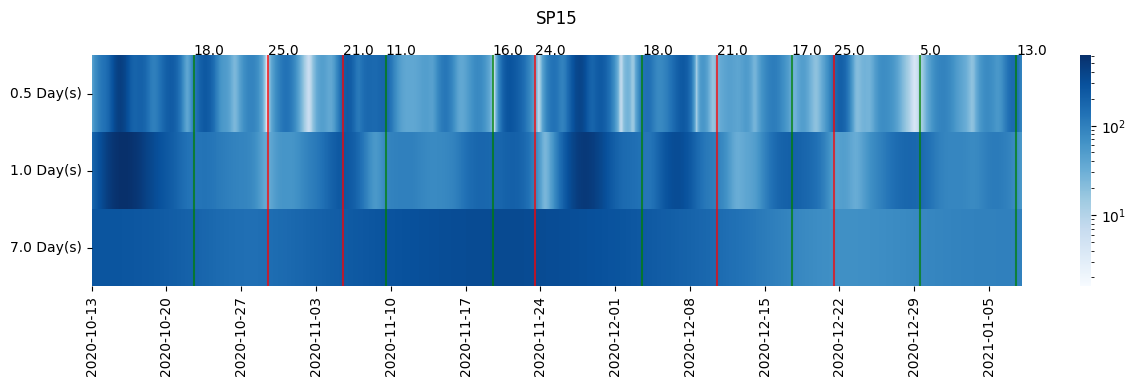

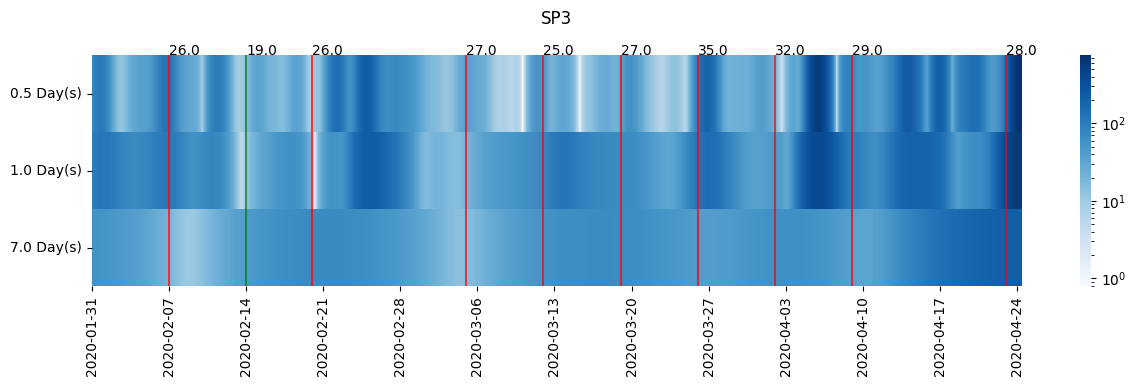

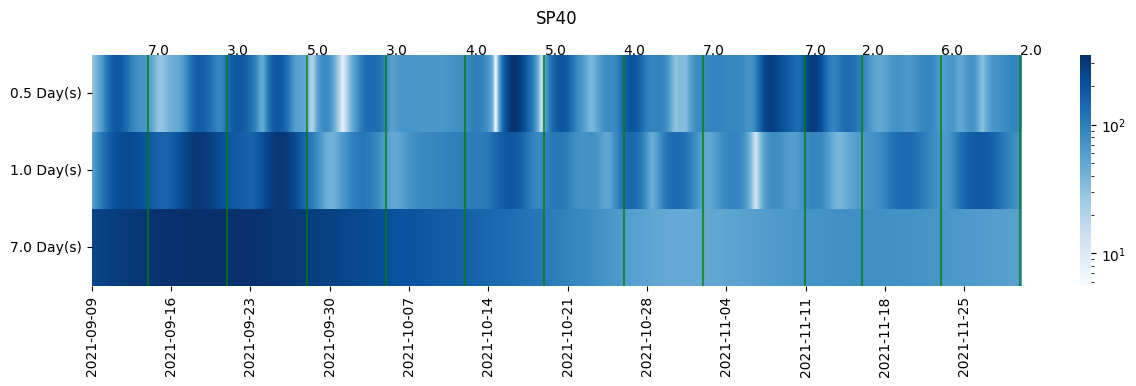

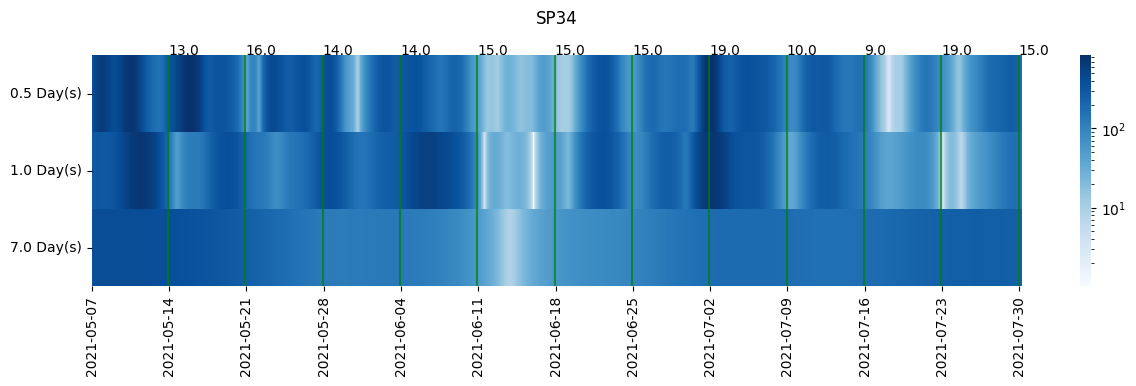

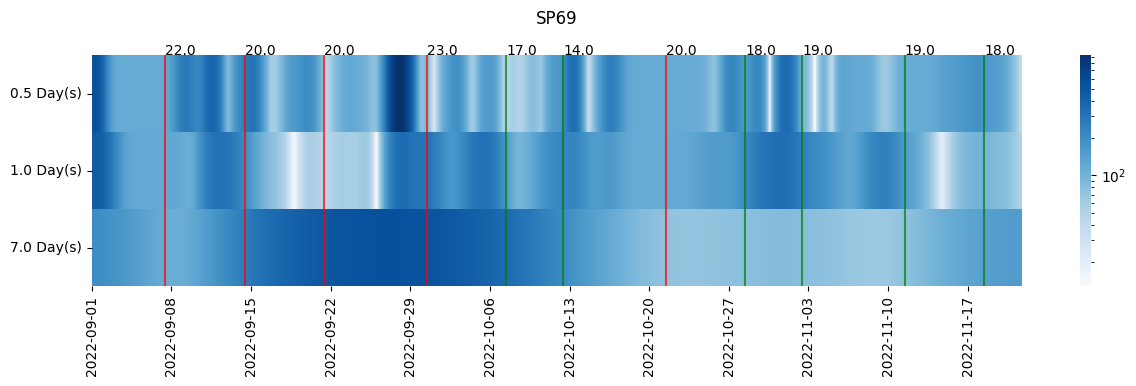

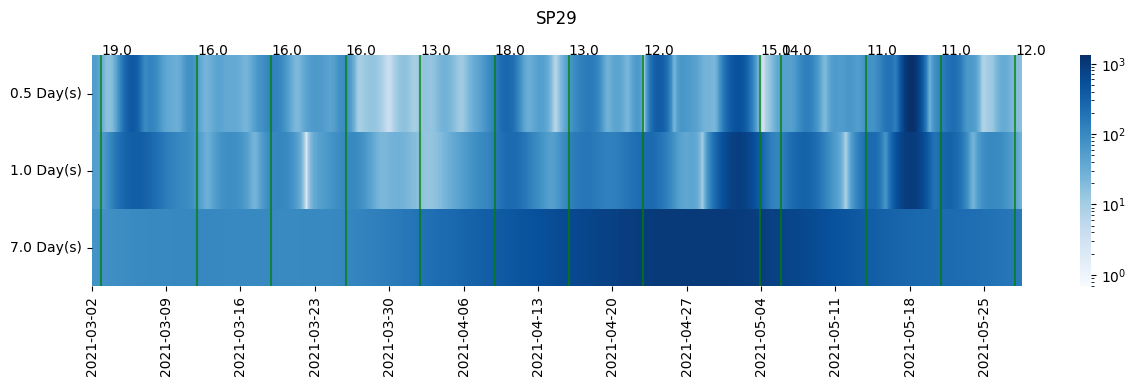

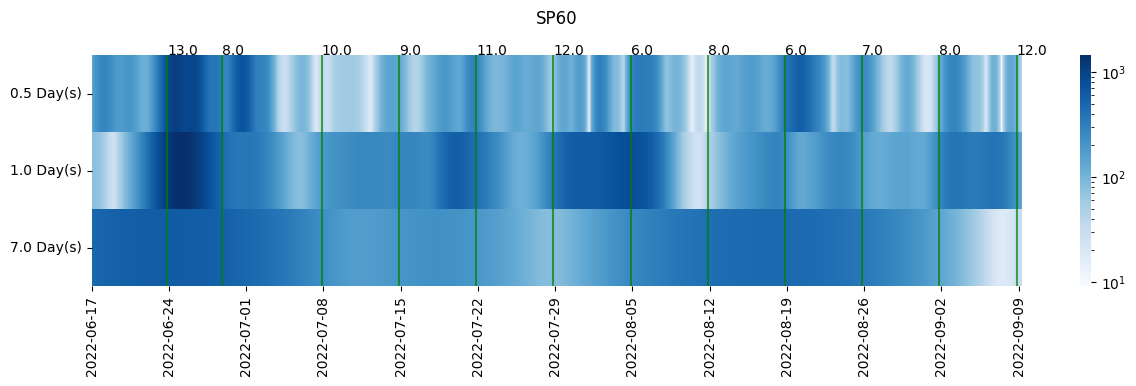

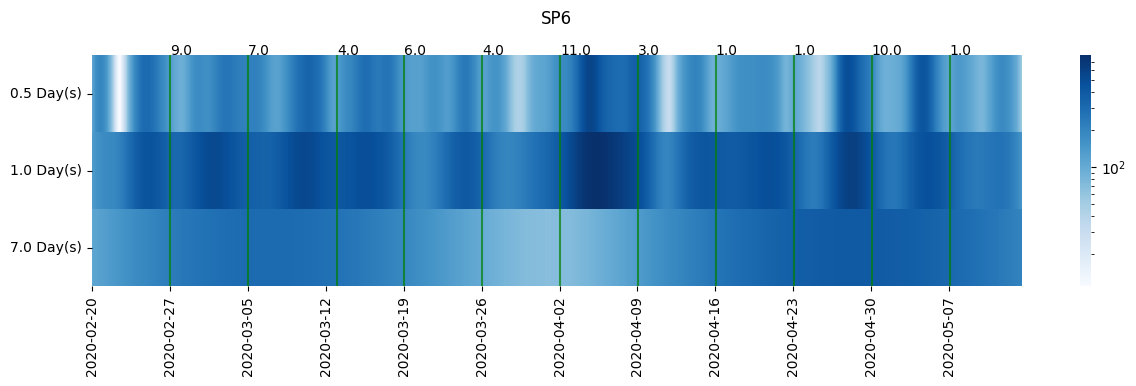

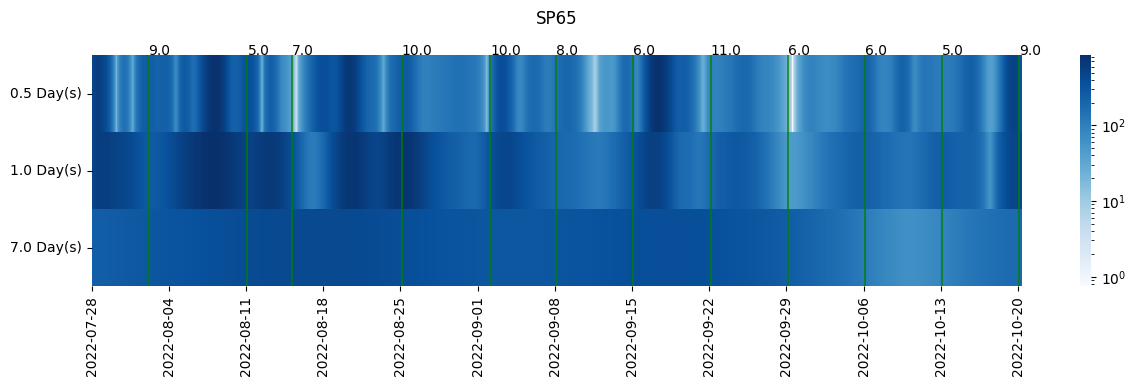

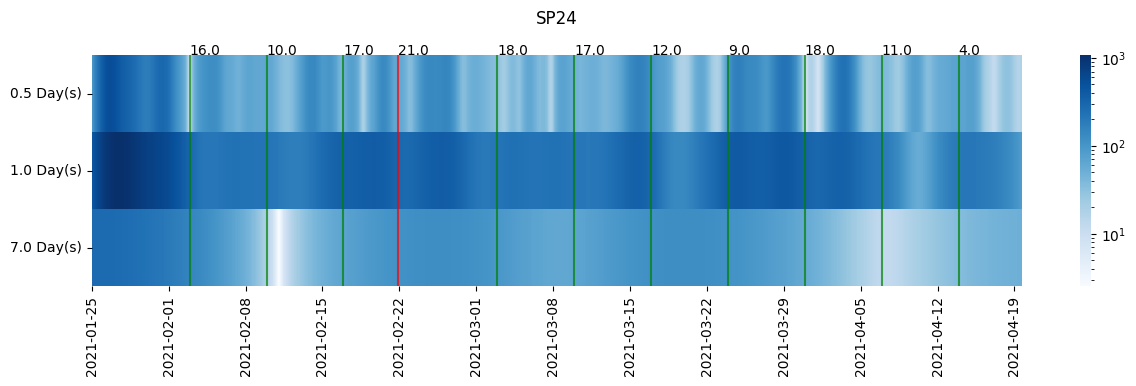

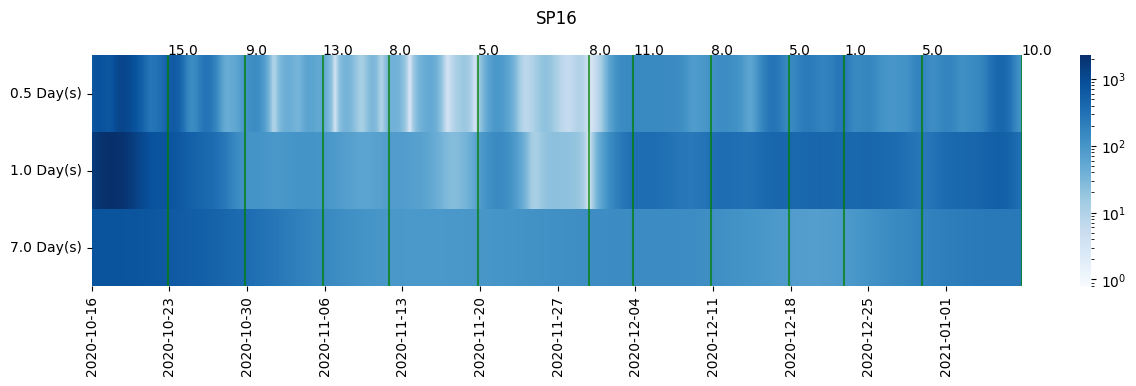

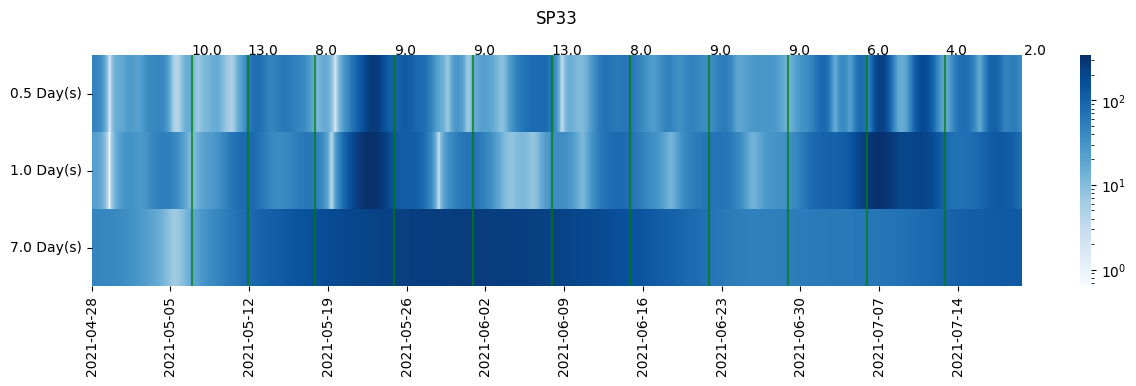

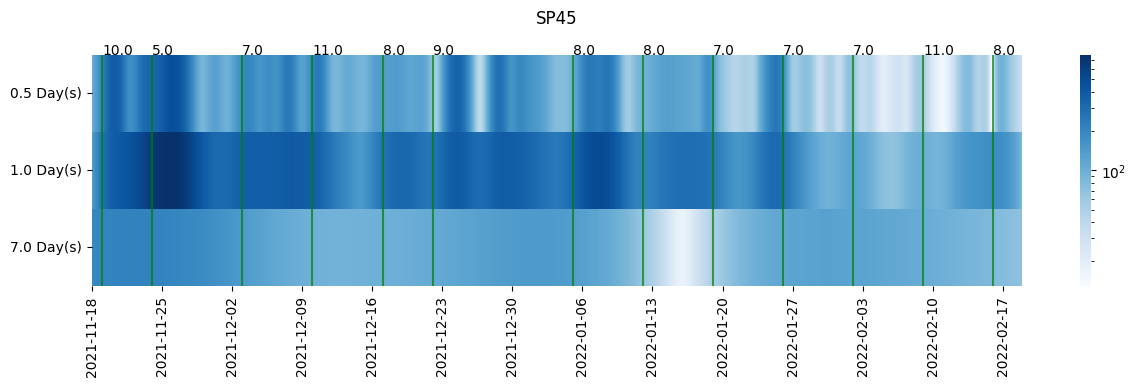

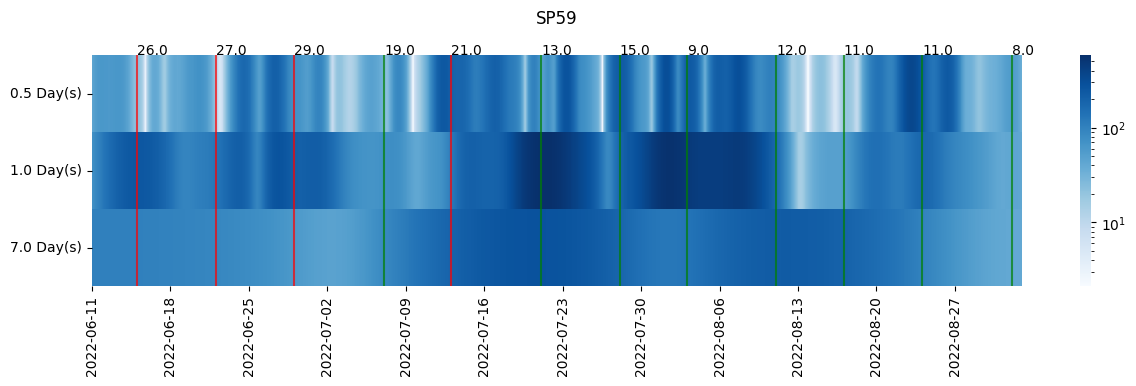

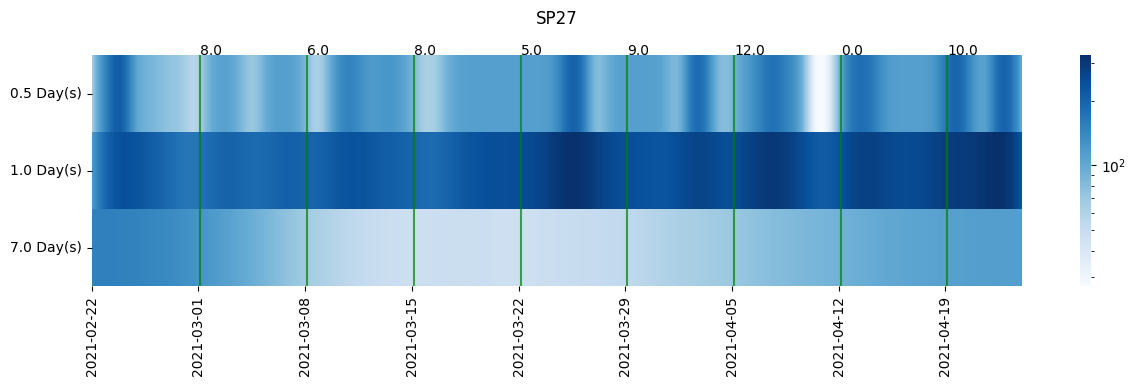

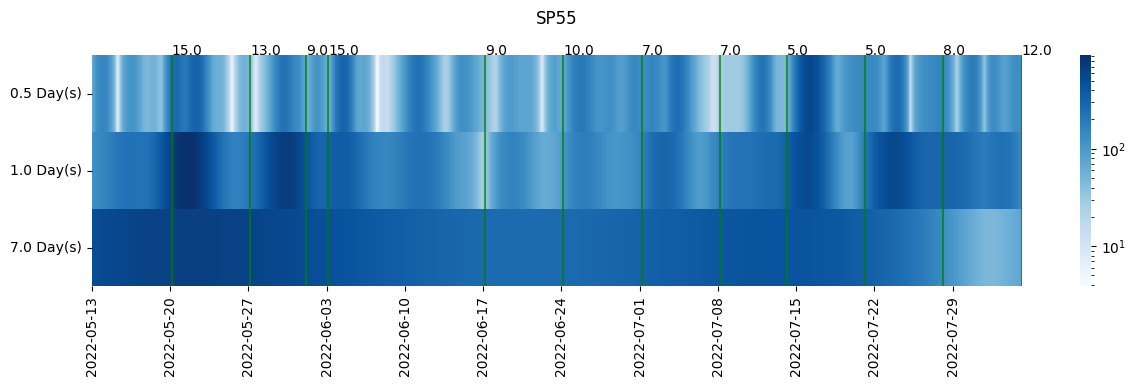

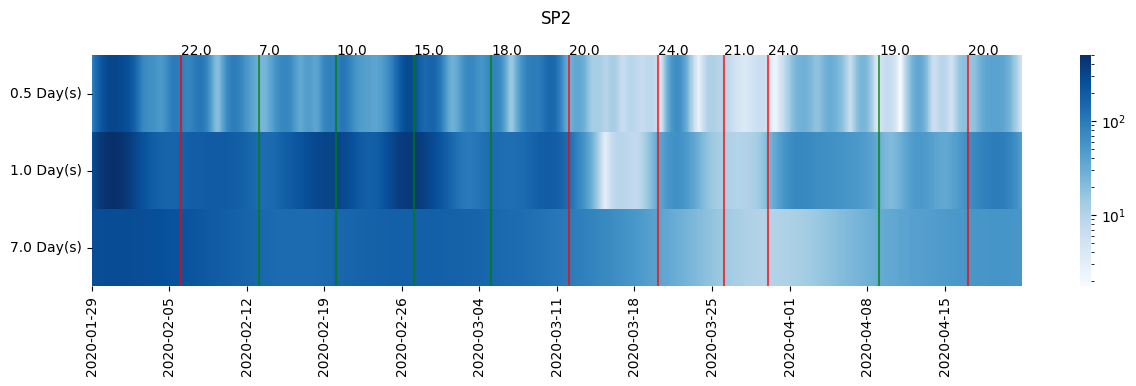

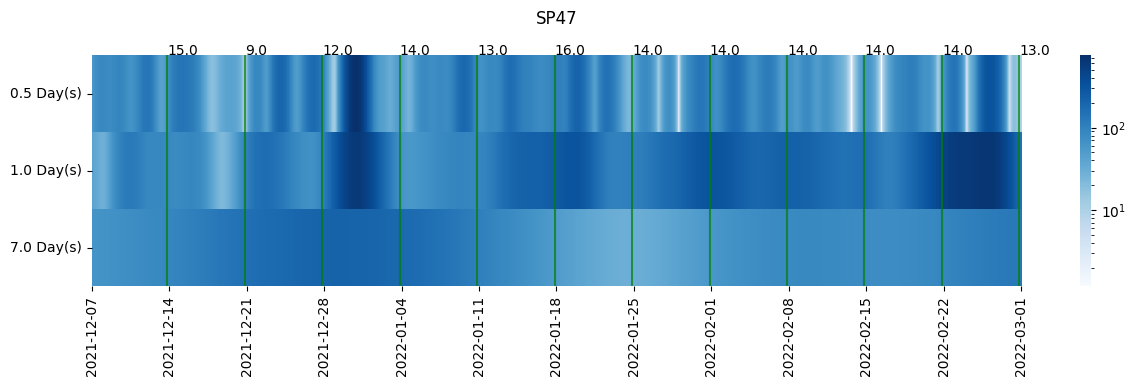

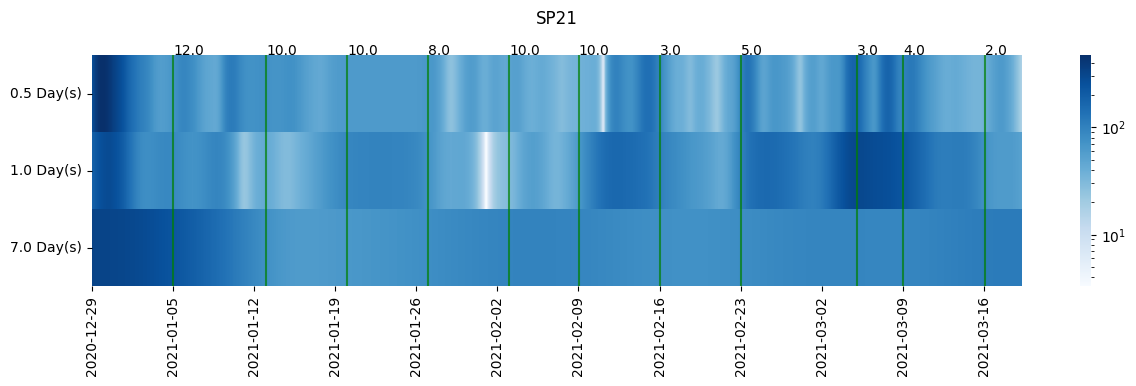

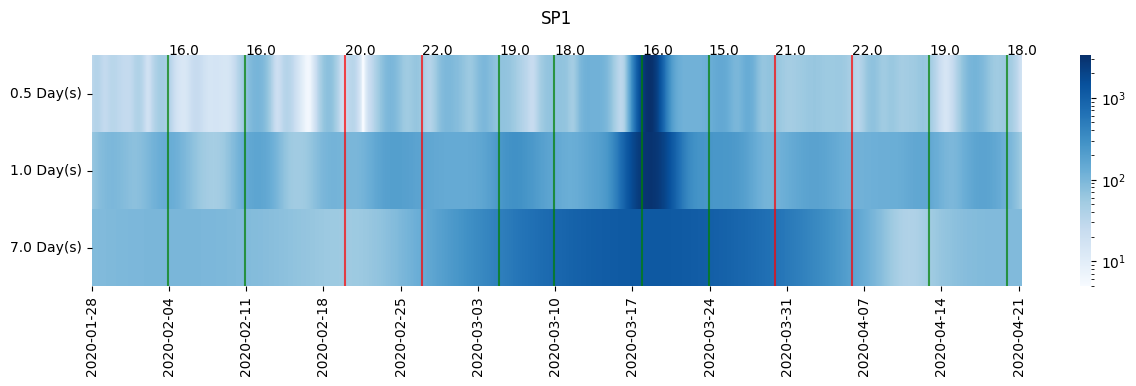

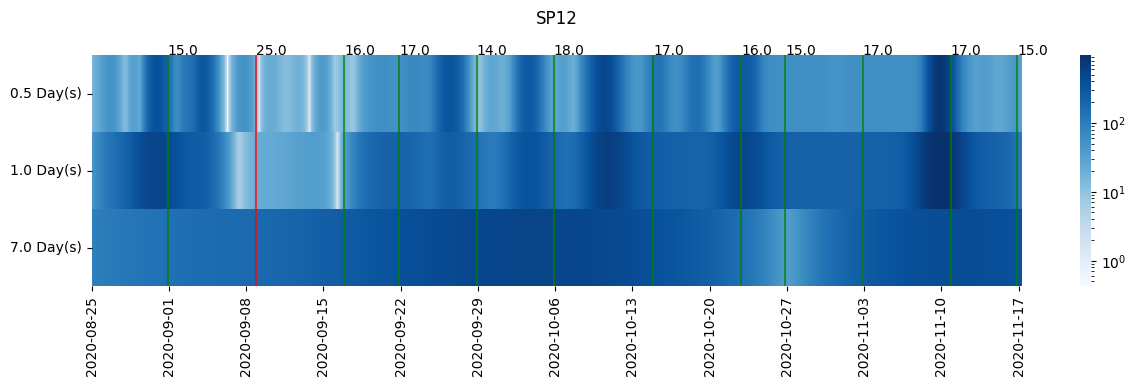

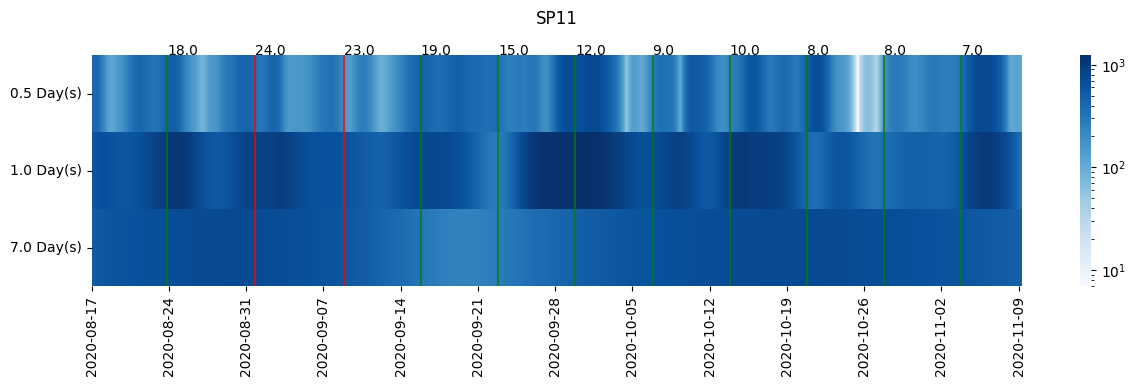

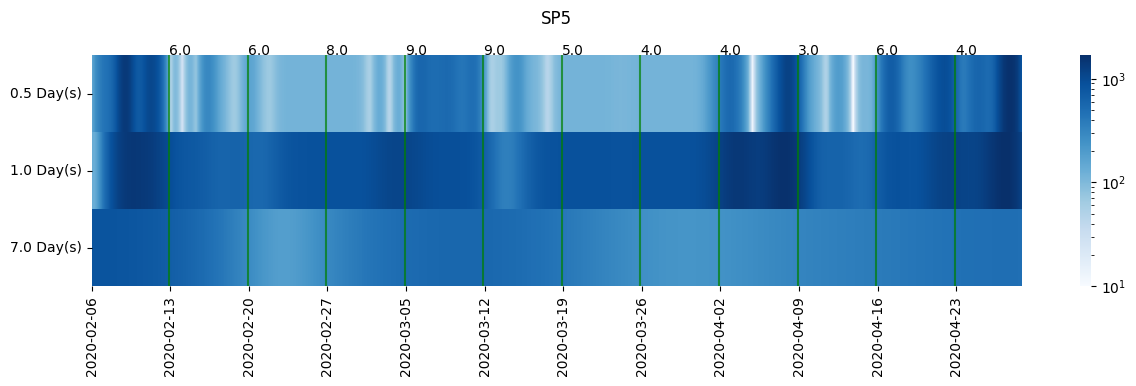

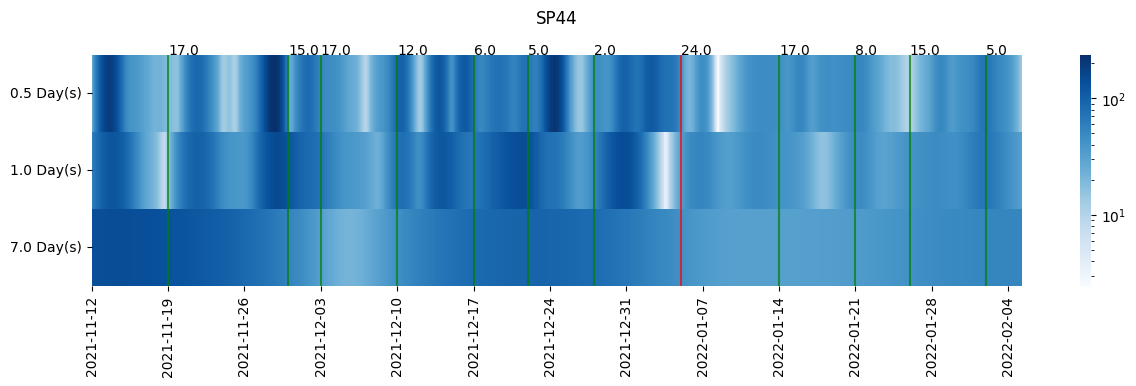

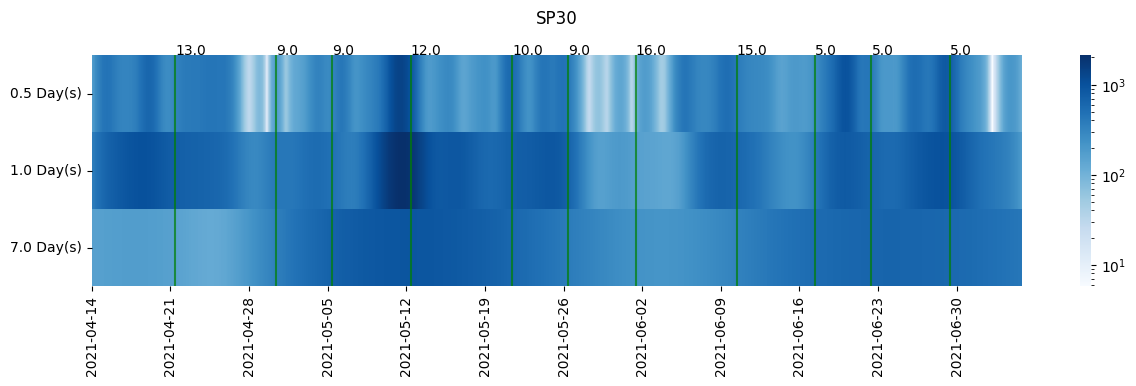

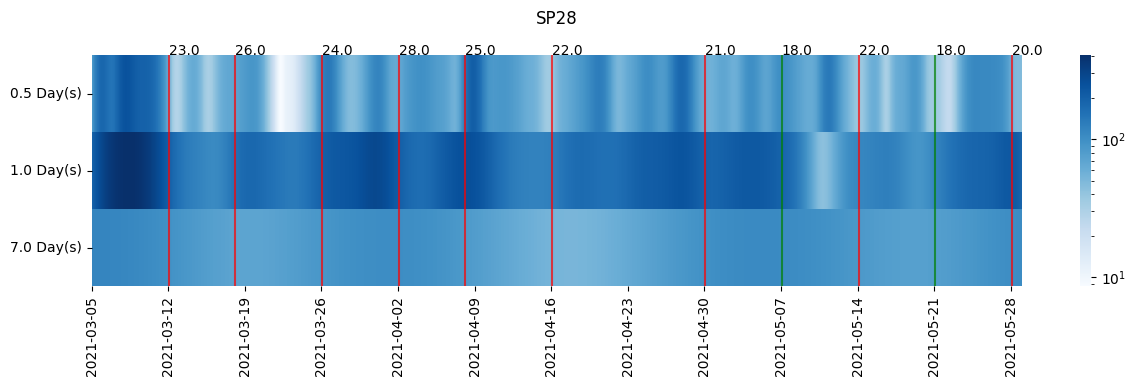

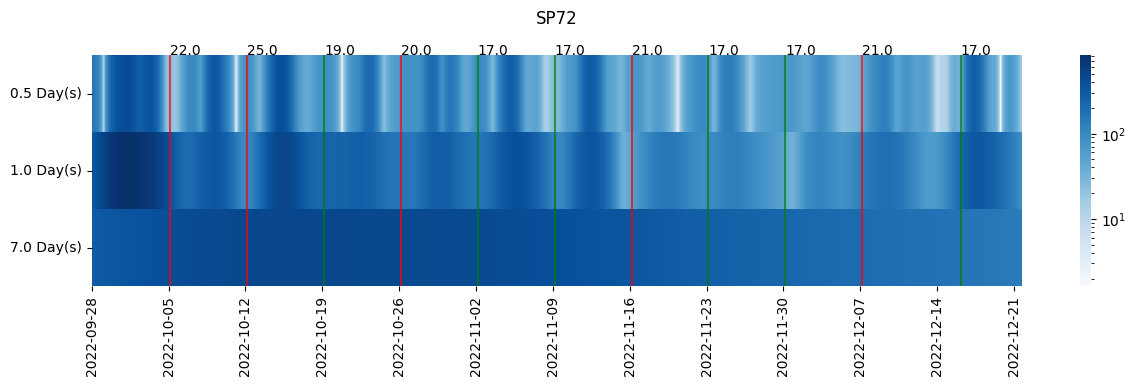

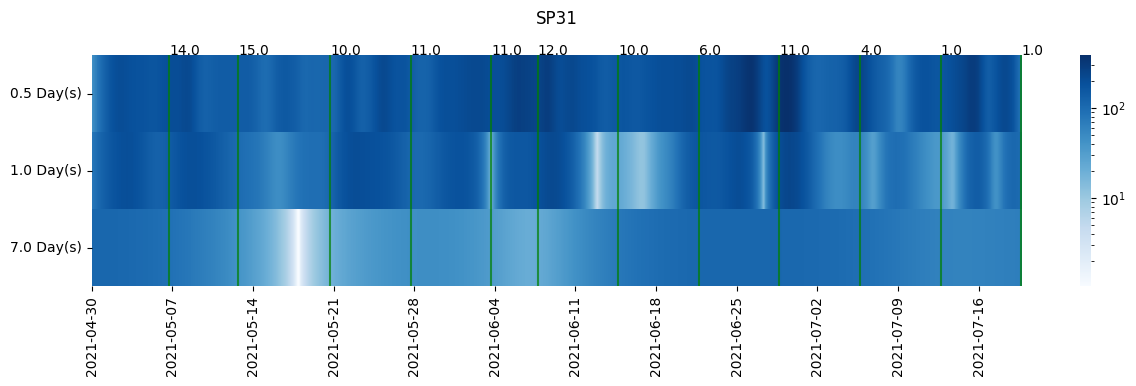

In [6]:
HDRS_variant = 'hamd_17_score'

for file in os.listdir(DATA_FOLDER):
    
    filename = os.fsdecode(file)
    
    if filename.endswith("cwt.h5"):
        
        subject = filename.split('_')[0]
        eda_filepath = DATA_FOLDER_PATH+filename
        retrieved = pd.read_hdf(eda_filepath, 'df')
        
        HDRS_file_name = LABEL_FOLDER_PATH + subject + '_HDRS.csv'
        HDRS_df = pd.read_csv(HDRS_file_name)
        
        HDRS_array = HDRS_df[HDRS_variant].to_numpy()        
        # sig_change_index = find_sig_HDRS_change(HDRS_array, 
        #                  RCI = RCI_HDRS_17, 
        #                  HDRS_cutoff = HDRS_17_CUTOFF)
                
        plot_morlet(df_eda = retrieved, 
                    freq_names = FREQ_NAMES, 
                    tick_freq = 'H', 
                    subject = subject, 
                    HDRS_array = HDRS_array,
                    sig_change_dates = HDRS_df['Date']) # plot all scores
        
